In [1]:
"""Code for generating figure 6
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline
import sys
import os
import scipy.stats as stats
from fears.population import Population
from fears.utils import plotter, fitness
from matplotlib import colors
from spatialentropy import leibovici_entropy, altieri_entropy
from datetime import date
from scipy.ndimage import convolve

In [2]:
dr_params = {
    'gmax':[0.0393, 0.0376, 0.0360, 0.0355],
    'gmin':[0.0179, 0.0286, 0.0337, 0.0296],
    'hc':[2.18, 2.19, 17.45, 1.85],
    'ic50':[0.0333, 0.0371, 0.020, 0.0530]
}

def hill_fn(conc,gmax, gmin, ic_50, hc):
    
    y = gmax + ((gmin - gmax) * conc**hc) / (ic_50**hc + conc**hc)
    return y

def gen_fit_land(conc,gmax,gmin,ic50,hc):
    fl = []

    for g in range(len(gmax)):
        fl.append(hill_fn(conc,gmax[g],gmin[g],ic50[g],hc[g]))
    return fl

cmap = sns.color_palette("colorblind", as_cmap=True)[0:4]
cmap_msw = ListedColormap(cmap)
cmap_agent = ListedColormap(['black'] + cmap)
cmap_charlength = sns.color_palette("colorblind", as_cmap=True)[5:9]

def get_most_fit_at_conc(data):
    most_fit = np.zeros(data.shape)
    for z in range(data.shape[0]):
        for j in range(data.shape[1]):
            # conc = 10**data[z,j]
            conc = data[z,j]
            p_fit_list = gen_fit_land(conc,**dr_params)
            most_fit[z,j] = int((np.argmax(p_fit_list)))
    return most_fit

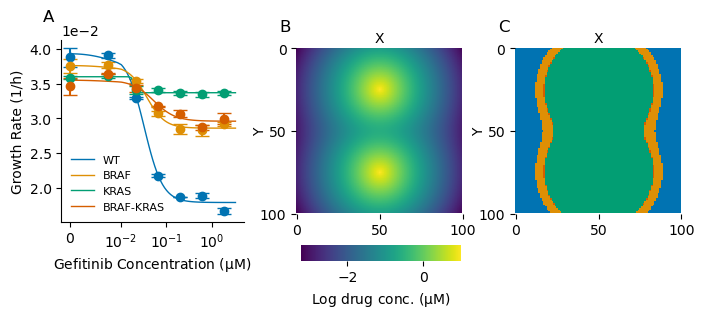

In [3]:
fig,ax_list = plt.subplots(ncols=3,figsize=(8,4))

ax = ax_list[0]

df = pd.read_csv('./data/gr_est.csv')

dc = df['drug_conc']*10**6 # uM

genotypes = ['wt','braf','kras','braf-kras']

indx = 0
for g in genotypes:
    y = df[g][0:-1]
    err = df[g+'_err'][0:-1]

    ax.errorbar(dc[0:-1],y,yerr=err,fmt='o',color=cmap[indx],capsize=5)
    indx += 1

gef_max = 1.8 # uM

dc = np.logspace(-4,np.log10(np.max(dc[0:-1])),100)*gef_max

# add a zero to the left side
dc = np.insert(dc,0,0)

dc = np.array(dc)

# labels = ['00','01','10','11']
labels = ['WT','BRAF','KRAS','BRAF-KRAS']

for g in range(4):
    y = hill_fn(dc, dr_params['gmax'][g], dr_params['gmin'][g], dr_params['ic50'][g], dr_params['hc'][g])
    ax.plot(dc, y, color=cmap[g], label=labels[g], linewidth=1)

ax.set_xscale('symlog',linthresh=10**-2)
ax.legend(frameon=False,loc='lower left',fontsize=8)

ax.set_xlabel('Gefitinib Concentration ($\mathrm{\mu}}$M)')
ax.set_ylabel('Growth Rate (1/h)')
ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = ax_list[1]

# today = date.today()
# date_str = today.strftime("%Y-%m-%d")

# data_folder = "./data/pc9_pulse_dosing_dense_grid/" + date_str

# dataDir = data_folder + "/cellCountDoseResponse_{}".format(1)
# load the diffGrid
dataDir = './data/pc9_pulse_dosing_dense_grid/2024-01-11/cellCountDoseResponse_1'

diffGridFile = dataDir + '/RepId_0_diffGrid.csv'
diffGrid = pd.read_csv(diffGridFile)
img_t = np.zeros((100,100))

img_t[diffGrid['x'],diffGrid['y']] = diffGrid['field']

diffimg = ax.imshow(np.log10(img_t),cmap='viridis')

# make the colorbar oriented horizontally

cbar_ax = fig.add_axes([0.425, 0.17, 0.2, 0.04])
cbar = fig.colorbar(diffimg, cax=cbar_ax,label='Log drug conc. ($\mathrm{\mu}$M)',orientation='horizontal')
cbar.outline.set_visible(False)

ax = ax_list[2]
# load an example diffusion grid

diffImg = img_t
msw = get_most_fit_at_conc(img_t)

# msw[img_t>1] = -1

ax.imshow(msw,cmap=cmap_msw,vmin=0,vmax=3,
            interpolation='nearest',interpolation_stage='rgba')

# make the leftmost axis the same height as the middle

for ax in ax_list[1:]:
    ax.set_ylabel('Y',labelpad=-5)
    ax.set_xlabel('X')
    ax.xaxis.set_label_position("top")

    ax.set_yticks([0,50,100])
    ax.set_xticks([0,50,100])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

height = ax_list[1].get_position().height
mid_pos = ax_list[1].get_position()
pos = ax_list[0].get_position()
ax_list[0].set_position([pos.x0,mid_pos.y0,pos.width,height])

# shift the middle and right axes right

pos = ax_list[1].get_position()
pos.x0 = pos.x0 + 0.02
ax_list[1].set_position(pos)

pos = ax_list[2].get_position()
pos.x0 = pos.x0 + 0.02
ax_list[2].set_position(pos)

label_list = ['A','B','C']
for i,ax in enumerate(ax_list):
    ax.annotate(label_list[i], xy=(-0.1, 1.1), xycoords='axes fraction',fontsize=12)

fig.savefig('./figures/pc9_seascape.pdf',bbox_inches='tight')

# fig.tight_layout()